# Classification using Multi-Layer Perceptrons


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_context("poster")

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Two additional imports here, seaborn and tqdm. Install via pip or conda

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf_predict, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=20):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))


    Z = clf_predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    showtr = ytr
    showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

## Create some noisy moon shaped data

In order to illustrate classification by a MLP, we first create some noisy moon shaped data. The *noise level* here and the *amount of data* is the first thing you might want to experiment with to understand the interplay of amount of data, noise level, number of parameters in the model we use to fit, and overfitting as illustrated by jagged boundaries.

We standardize the data so that it is distributed about 0 as well

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
dataX, datay = make_moons(noise=0.35, n_samples=400, random_state=2017)
dataX = StandardScaler().fit_transform(dataX)
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=.4)

In [11]:
X_train.shape

(240, 2)

(-3.2335303391258776, 3.346469660874128)

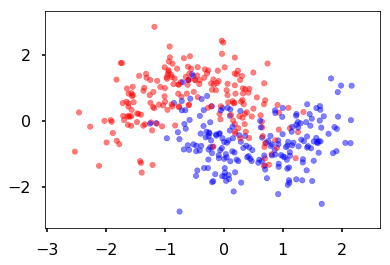

In [5]:
h=.02
x_min, x_max = dataX[:, 0].min() - .5, dataX[:, 0].max() + .5
y_min, y_max = dataX[:, 1].min() - .5, dataX[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.gca()
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.5, s=30)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.5, s=30)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import torch.utils.data

## Writing a Multi-Layer Perceptron class

We wrap the construction of our network 

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(MLP, self).__init__()
        self.fc_initial = nn.Linear(input_dim, hidden_dim)
        self.fc_mid = nn.ModuleList()
        self.additional_hidden_wide = additional_hidden_wide
        for i in range(self.additional_hidden_wide):
            self.fc_mid.append(nn.Linear(hidden_dim, hidden_dim))
        if self.additional_hidden_wide != -1:
            self.fc_final = nn.Linear(hidden_dim, output_dim)
        self.nonlinearity = nonlinearity

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.nonlinearity(x)
        if self.additional_hidden_wide != -1:
            for i in range(self.additional_hidden_wide):
                x = self.fc_mid[i](x)
                x = self.nonlinearity(x)
            x = self.fc_final(x)
        return x

We use it to train. Notice the double->float casting. Numpy defautlts to double but torch defaulta to float to enable memory efficient GPU usage.

In [8]:
np.dtype(np.float).itemsize, np.dtype(np.double).itemsize

(8, 8)

But torch floats are 4 byte as can be seen from here: http://pytorch.org/docs/master/tensors.html


### Training the model

Points to note:

- printing a model prints its layers, handy. Note that we implemented layers as functions. The autodiff graph is constructed on the fly on the first forward pass and used in backward.
- we had to cast to float
- `model.parameters` gives us params, `model.named_parameters()` gives us assigned names. You can set your own names when you create a layer
- we create an iterator over the data, more precisely over batches by doing `iter(loader)`. This dispatches to the `__iter__` method of the dataloader. (see https://github.com/pytorch/pytorch/blob/4157562c37c76902c79e7eca275951f3a4b1ef78/torch/utils/data/dataloader.py#L416) Always explore source code to understand what is going on

MLP(
  (fc_initial): Linear(in_features=2, out_features=3, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
  (fc_final): Linear(in_features=3, out_features=2, bias=True)
)


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


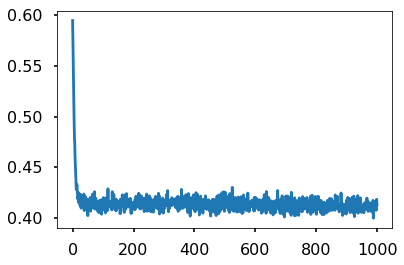

In [12]:
model2 = MLP(input_dim=2, hidden_dim=3, output_dim=2, nonlinearity=fn.tanh, additional_hidden_wide=1)
print(model2)
criterion = nn.CrossEntropyLoss(size_average=True)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
lr, epochs, batch_size = 1e-1 , 1000 , 64
optimizer = torch.optim.SGD(model2.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for localx, localy in iter(loader):
        localx = Variable(localx.float())
        localy = Variable(localy.long())
        output = model2.forward(localx)
        loss = criterion(output, localy)
        model2.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.item())
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

The out put from the foward pass is run on the entire test set. Since pytorch tracks layers upto but before the loss, this handily gives us the softmax output, which we can then use `np.argmax` on.

In [13]:
testoutput = model2.forward(Variable(torch.from_numpy(X_test).float()))
testoutput

//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[-0.1656, -0.8625],
        [ 0.4206, -1.7611],
        [-0.1149, -0.9044],
        [-1.1444,  1.0053],
        [-1.1911,  1.1099],
        [-1.1720,  1.0803],
        [ 0.3678, -1.6895],
        [ 0.1054, -1.2455],
        [ 0.3648, -1.6861],
        [ 0.5942, -2.0163],
        [-0.4780, -0.3648],
        [-0.9152,  0.4497],
        [ 0.0058, -1.1349],
        [-1.1122,  0.9690],
        [ 0.5691, -1.9963],
        [-0.6769, -0.0052],
        [-1.2145,  1.1847],
        [-1.2156,  1.1793],
        [ 0.2338, -1.4129],
        [-0.8965,  0.4202],
        [ 0.5710, -1.9908],
        [-0.6301, -0.0371],
        [-0.8433,  0.3883],
        [ 0.3247, -1.6016],
        [-0.9345,  0.5534],
        [-0.9029,  0.4916],
        [-1.1529,  1.0223],
        [-1.2135,  1.1814],
        [ 0.5289, -1.9320],
        [-1.1642,  1.0696],
        [-1.2126,  1.1766],
        [ 0.1673, -1.3393],
        [ 0.5233, -1.9264],
        [-1.1272,  0.9683],
        [-1.2066,  1.1879],
        [-0.9648,  0

In [14]:
y_pred = testoutput.data.numpy().argmax(axis=1)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1])

You can write your own but we import some metrics from sklearn

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test, y_pred)

array([[58, 16],
       [10, 76]])

In [16]:
accuracy_score(y_test, y_pred)

0.8375

We can wrap this machinery in a function, and pass this function to `points_plot` to predict on a grid and thus give us a boundary viz

In [17]:
def make_pred(X_set):
    output = model2.forward(Variable(torch.from_numpy(X_set).float()))
    return output.data.numpy().argmax(axis=1)

//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


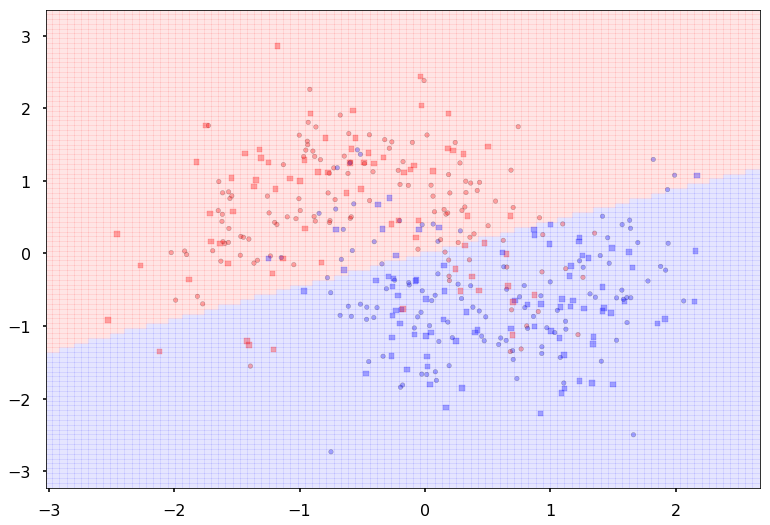

In [18]:
with sns.plotting_context('poster'):
    ax = plt.gca()
    points_plot(ax, X_train, X_test, y_train, y_test, make_pred);

## Making a `scikit-learn` like interface

Since we want to run many experiments, we'll go ahead and wrap our fitting process in a sklearn style interface. Another example of such an interface is [here](https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/3_neural_net.py)

In [29]:
from tqdm import tnrange, tqdm_notebook
class MLPClassifier:
    
    def __init__(self, input_dim, hidden_dim, 
                 output_dim, nonlinearity = fn.tanh, 
                 additional_hidden_wide=0, reg=0):
        self._pytorch_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity, additional_hidden_wide)
        self._criterion = nn.CrossEntropyLoss(size_average=True)
        self._fit_params = dict(lr=0.1, epochs=200, batch_size=64, reg=reg)
        self._optim = torch.optim.SGD(self._pytorch_model.parameters(), lr = self._fit_params['lr'], weight_decay=self._fit_params['reg'] )
        
    def __repr__(self):
        num=0
        for k, p in self._pytorch_model.named_parameters():
            numlist = list(p.data.numpy().shape)
            if len(numlist)==2:
                num += numlist[0]*numlist[1]
            else:
                num+= numlist[0]
        return repr(self._pytorch_model)+"\n"+repr(self._fit_params)+"\nNum Params: {}".format(num)
    
    def set_fit_params(self, *, lr=0.1, epochs=200, batch_size=64, reg=0):
        self._fit_params['batch_size'] = batch_size
        self._fit_params['epochs'] = epochs
        self._fit_params['lr'] = lr
        self.fit_params['reg'] = reg
        self._optim = torch.optim.SGD(self._pytorch_model.parameters(), lr = self._fit_params['lr'], weight_decay=self._fit_params['reg'] )
        
    def fit(self, X_train, y_train):
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        loader = torch.utils.data.DataLoader(dataset, batch_size=self._fit_params['batch_size'], shuffle=True)
        self._accum=[]
        for k in tnrange(self._fit_params['epochs']):
            localaccum = []
            for localx, localy in iter(loader):
                localx = Variable(localx.float())
                localy = Variable(localy.long())
                output = self._pytorch_model.forward(localx)
                loss = self._criterion(output, localy)
                self._pytorch_model.zero_grad()
                loss.backward()
                self._optim.step()
                localaccum.append(loss.item())
            self._accum.append(np.mean(localaccum))
        
    def plot_loss(self):
        plt.plot(self._accum, label="{}".format(self))
        plt.legend()
        plt.show()
        
    def plot_boundary(self, X_train, X_test, y_train, y_test):
        points_plot(plt.gca(), X_train, X_test, y_train, y_test, self.predict);
        plt.text(1, 1, "{}".format(self), fontsize=12)
        plt.show()
        
    def predict(self, X_test):
        output = self._pytorch_model.forward(Variable(torch.from_numpy(X_test).float()))
        return output.data.numpy().argmax(axis=1)
        

Some points about this:

- we provide the ability to change the fitting parameters
- by implementing a `__repr__` we let an instance of this class print something useful. Specifically we created a count of the number of parameters so that we can get a comparison of data size to parameter size.

## The simplest model, and a more complex model

In [20]:
logistic = MLPClassifier(input_dim=2, hidden_dim=2, output_dim=2, nonlinearity=lambda x: x, additional_hidden_wide=-1)
logistic.set_fit_params(epochs=1000)
print(logistic)
logistic.fit(X_train,y_train)

MLP(
  (fc_initial): Linear(in_features=2, out_features=2, bias=True)
  (fc_mid): ModuleList()
)
{'lr': 0.1, 'epochs': 1000, 'batch_size': 64}
Num Params: 6


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Widget Javascript not detected.  It may not be installed or enabled properly.


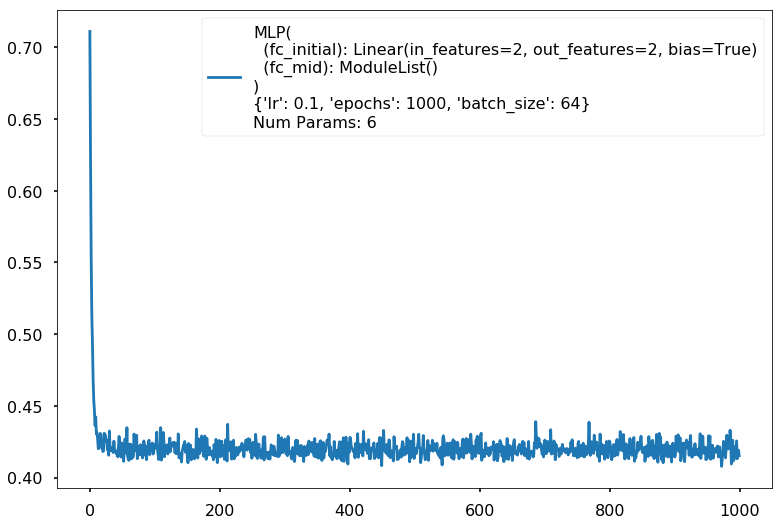

In [21]:
with sns.plotting_context('poster'):
    logistic.plot_loss()

In [22]:
ypred = logistic.predict(X_test)
#training and test accuracy
accuracy_score(y_train, logistic.predict(X_train)), accuracy_score(y_test, ypred)

(0.8333333333333334, 0.8375)

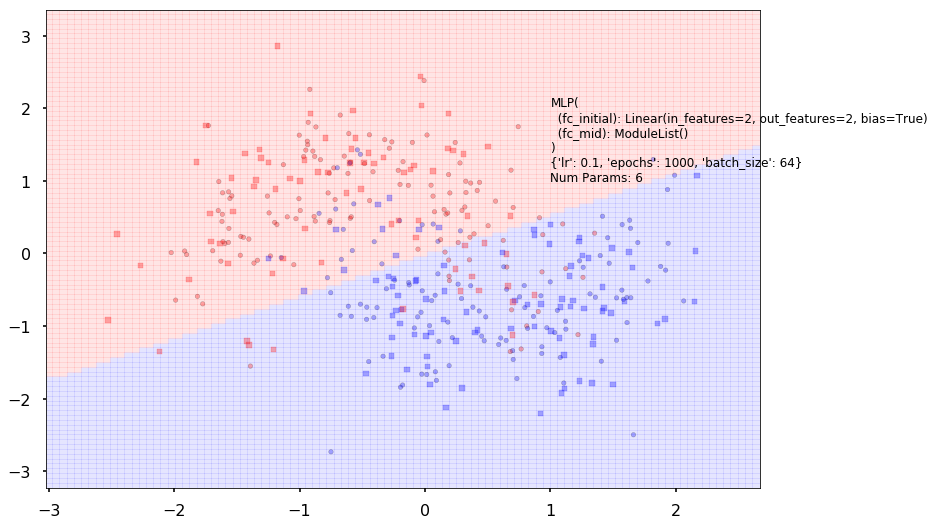

In [23]:
with sns.plotting_context('poster'):
    logistic.plot_boundary(X_train, X_test, y_train, y_test)

In [24]:
clf = MLPClassifier(input_dim=2, hidden_dim=20, output_dim=2, nonlinearity=fn.tanh, additional_hidden_wide=1)
clf.set_fit_params(epochs=1000)
print(clf)
clf.fit(X_train,y_train)

MLP(
  (fc_initial): Linear(in_features=2, out_features=20, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
  )
  (fc_final): Linear(in_features=20, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 1000, 'batch_size': 64}
Num Params: 522


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Widget Javascript not detected.  It may not be installed or enabled properly.


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


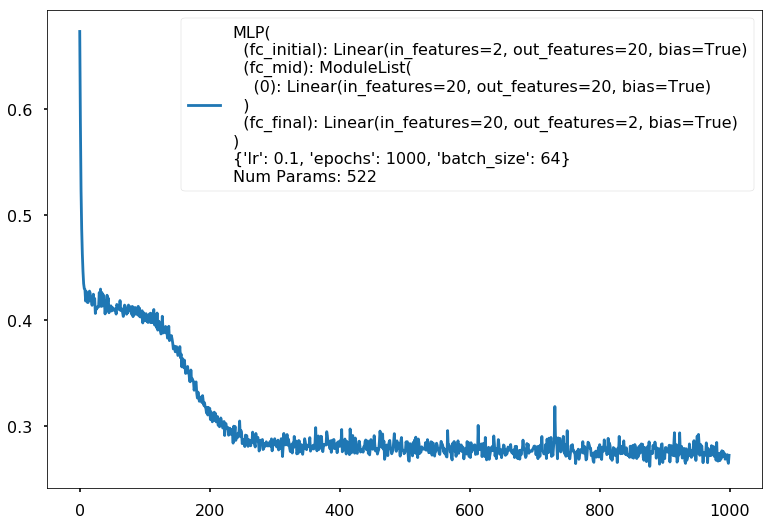

In [25]:
with sns.plotting_context('poster'):
    clf.plot_loss()

In [26]:
ypred = clf.predict(X_test)
#training and test accuracy
accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, ypred)

//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(0.8708333333333333, 0.8625)

//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


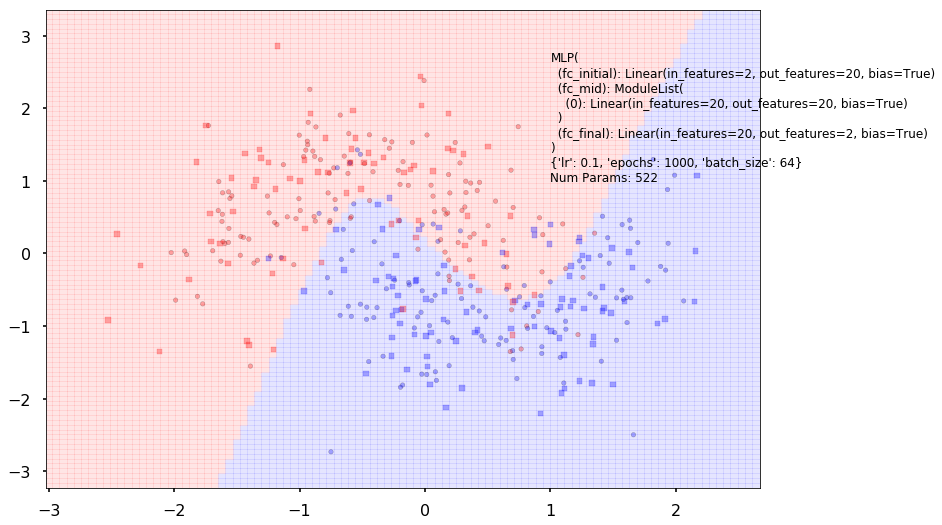

In [27]:
with sns.plotting_context('poster'):
    clf.plot_boundary(X_train, X_test, y_train, y_test)

## Experimentation Space

Here is space for you to play. You might want to collect accuracies on the traing and test set and plot on a grid of these parameters or some other visualization. Notice how you might want to adjust number of epochs for convergence.

Additional 0 hidden 2
MLP(
  (fc_initial): Linear(in_features=2, out_features=2, bias=True)
  (fc_mid): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 12


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Widget Javascript not detected.  It may not be installed or enabled properly.


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


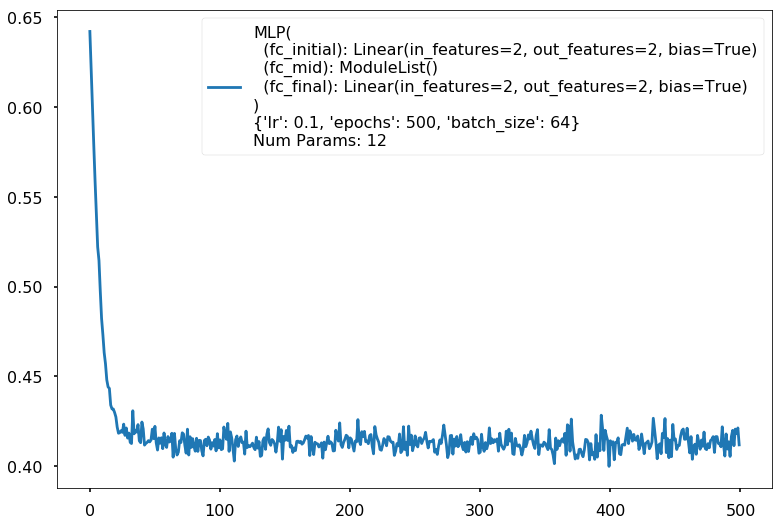

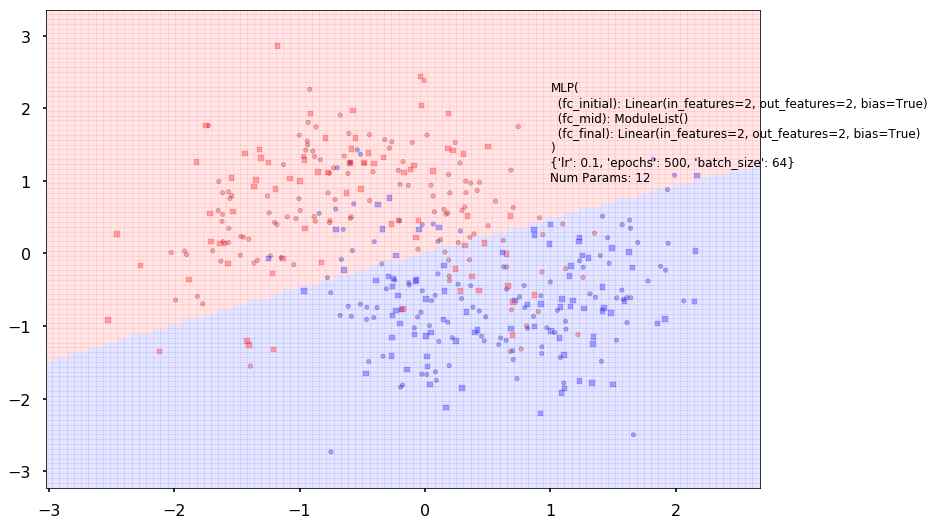

Train acc 0.8291666666666667
Test acc 0.8375
Additional 0 hidden 10
MLP(
  (fc_initial): Linear(in_features=2, out_features=10, bias=True)
  (fc_mid): ModuleList()
  (fc_final): Linear(in_features=10, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 52


Widget Javascript not detected.  It may not be installed or enabled properly.


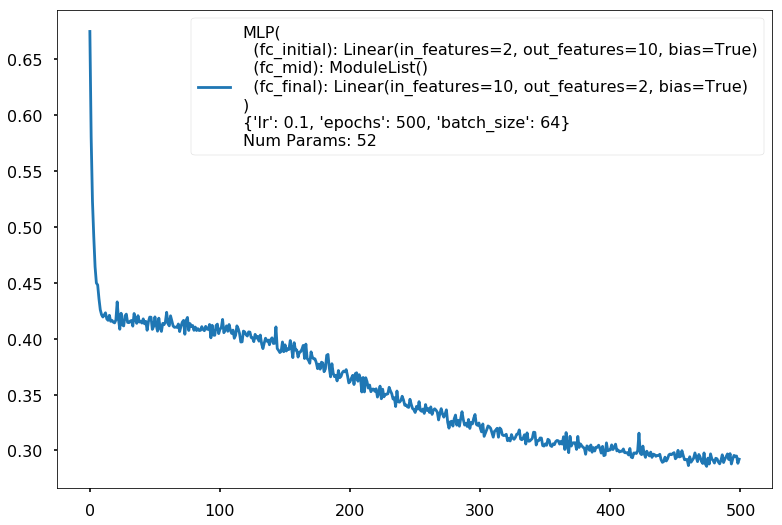

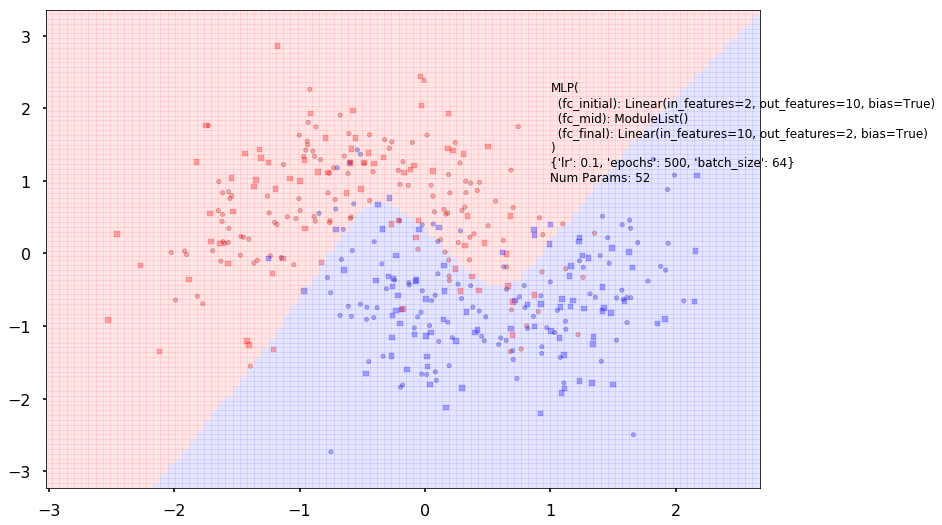

Train acc 0.8791666666666667
Test acc 0.85625
Additional 0 hidden 100
MLP(
  (fc_initial): Linear(in_features=2, out_features=100, bias=True)
  (fc_mid): ModuleList()
  (fc_final): Linear(in_features=100, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 502


Widget Javascript not detected.  It may not be installed or enabled properly.


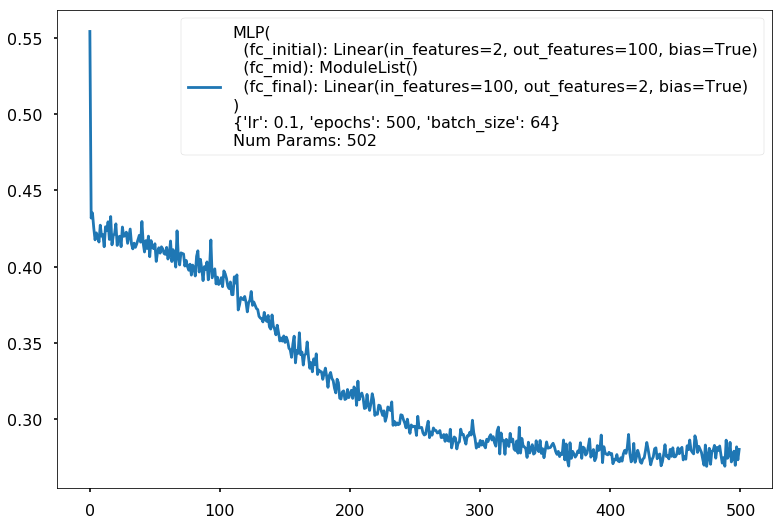

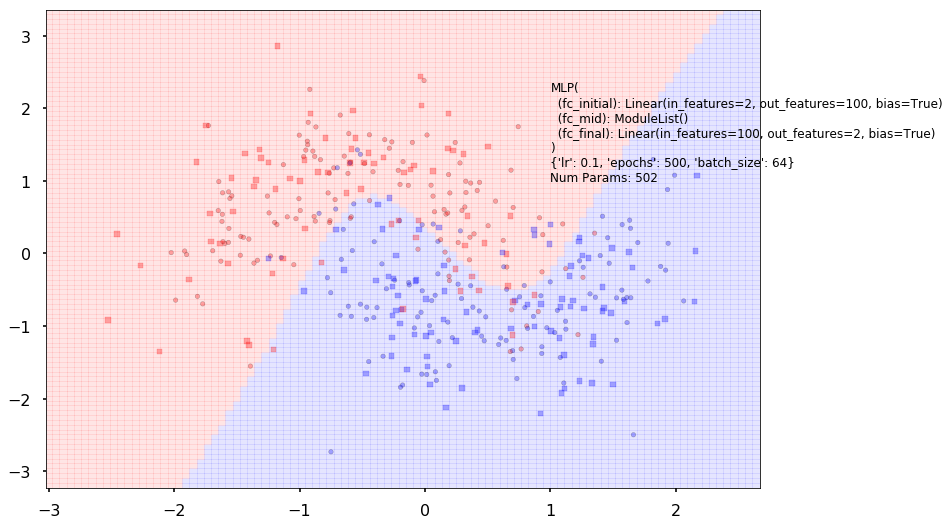

Train acc 0.8708333333333333
Test acc 0.86875
Additional 0 hidden 1000
MLP(
  (fc_initial): Linear(in_features=2, out_features=1000, bias=True)
  (fc_mid): ModuleList()
  (fc_final): Linear(in_features=1000, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 5002


Widget Javascript not detected.  It may not be installed or enabled properly.


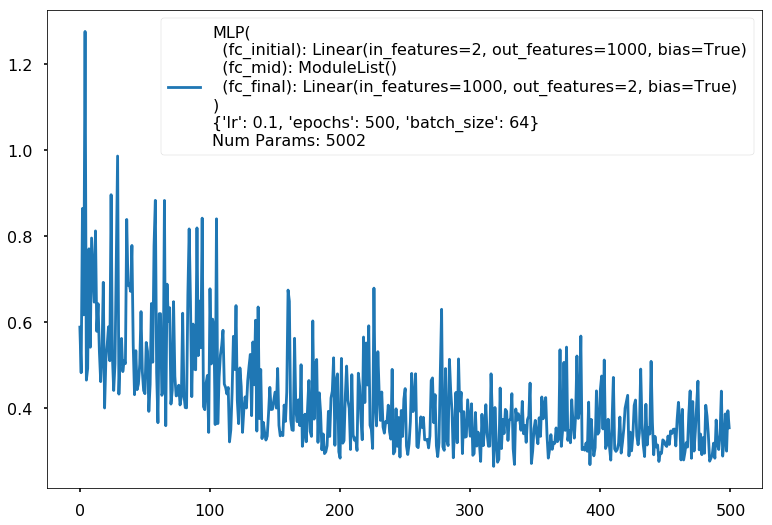

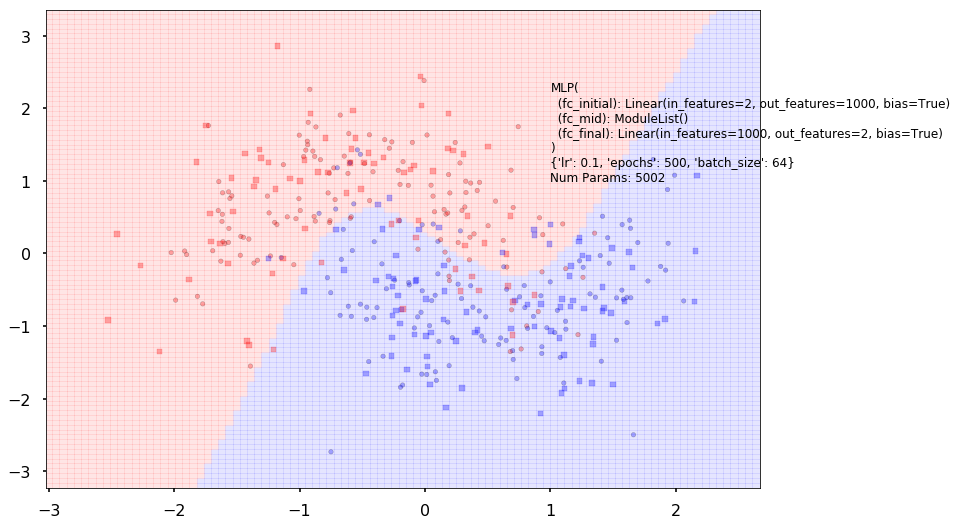

Train acc 0.875
Test acc 0.85
Additional 2 hidden 2
MLP(
  (fc_initial): Linear(in_features=2, out_features=2, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 24


Widget Javascript not detected.  It may not be installed or enabled properly.


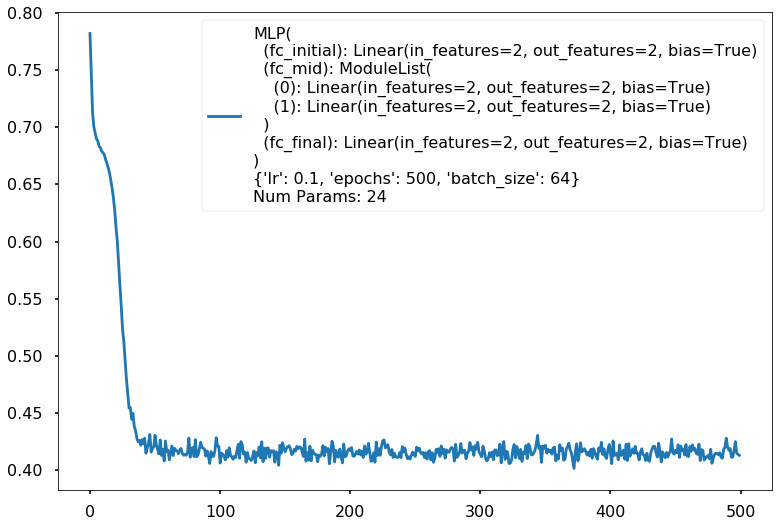

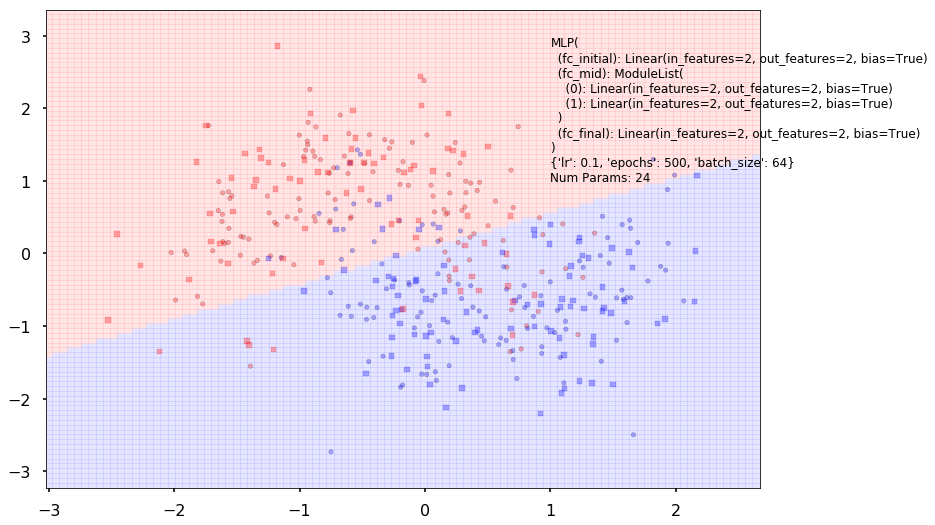

Train acc 0.825
Test acc 0.84375
Additional 2 hidden 10
MLP(
  (fc_initial): Linear(in_features=2, out_features=10, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc_final): Linear(in_features=10, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 272


Widget Javascript not detected.  It may not be installed or enabled properly.


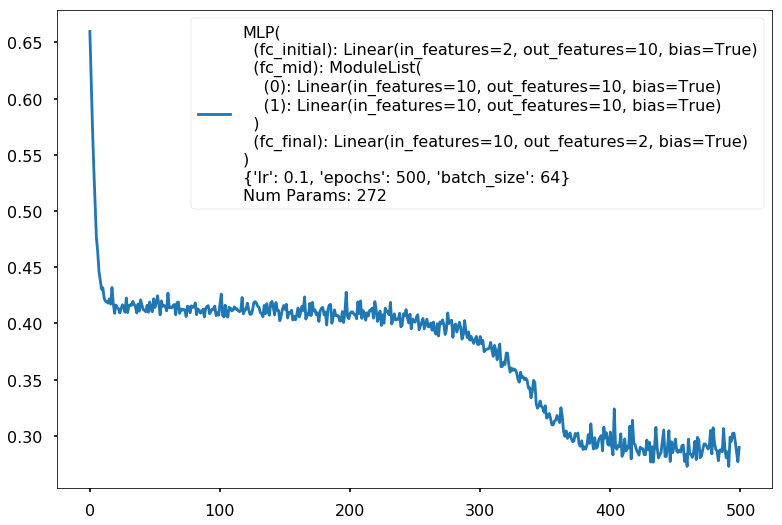

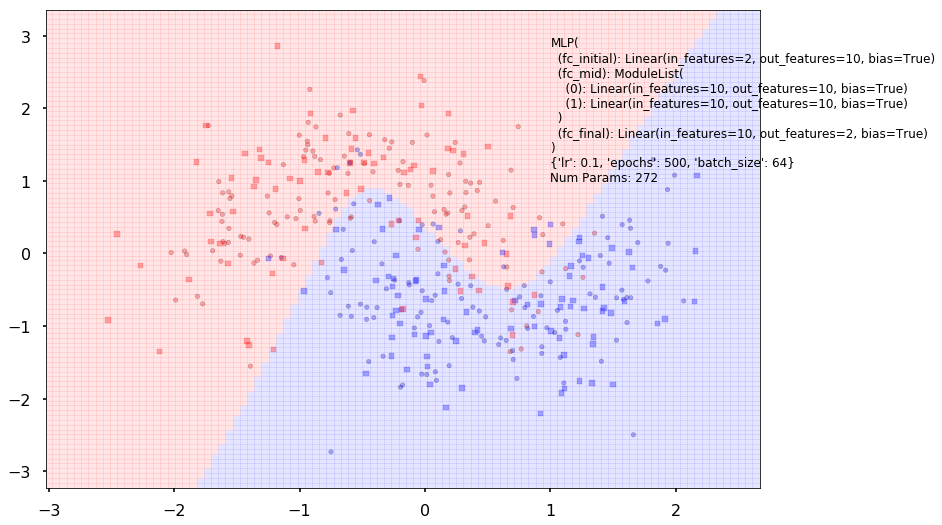

Train acc 0.875
Test acc 0.875
Additional 2 hidden 100
MLP(
  (fc_initial): Linear(in_features=2, out_features=100, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 20702


Widget Javascript not detected.  It may not be installed or enabled properly.


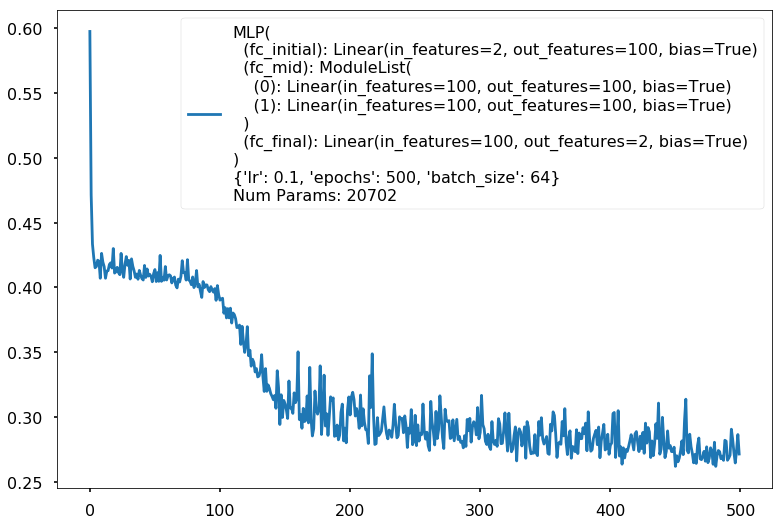

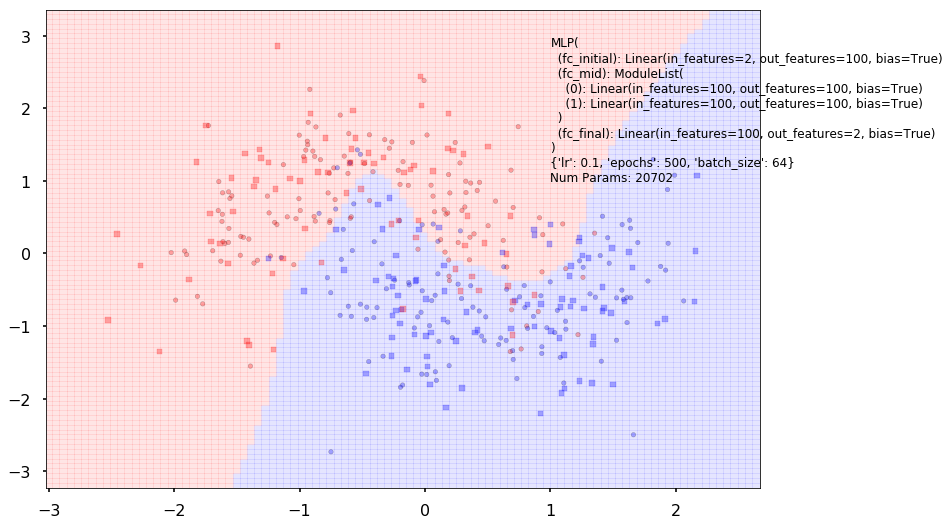

Train acc 0.8875
Test acc 0.8625
Additional 2 hidden 1000
MLP(
  (fc_initial): Linear(in_features=2, out_features=1000, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
  )
  (fc_final): Linear(in_features=1000, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 2007002


Widget Javascript not detected.  It may not be installed or enabled properly.


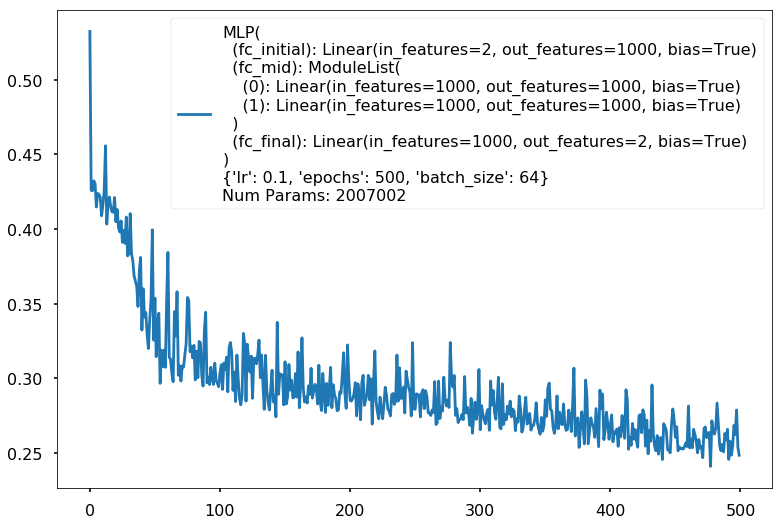

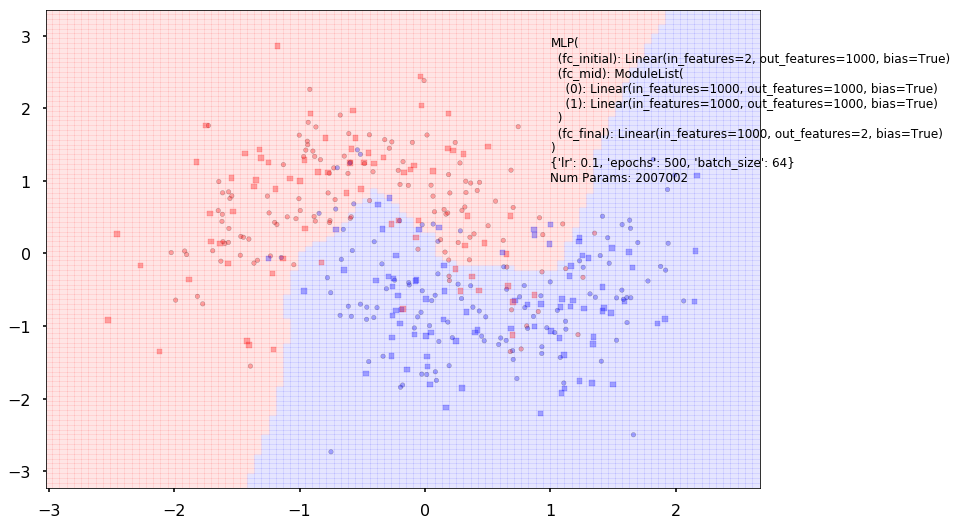

Train acc 0.8833333333333333
Test acc 0.85625
Additional 4 hidden 2
MLP(
  (fc_initial): Linear(in_features=2, out_features=2, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Linear(in_features=2, out_features=2, bias=True)
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 36


Widget Javascript not detected.  It may not be installed or enabled properly.


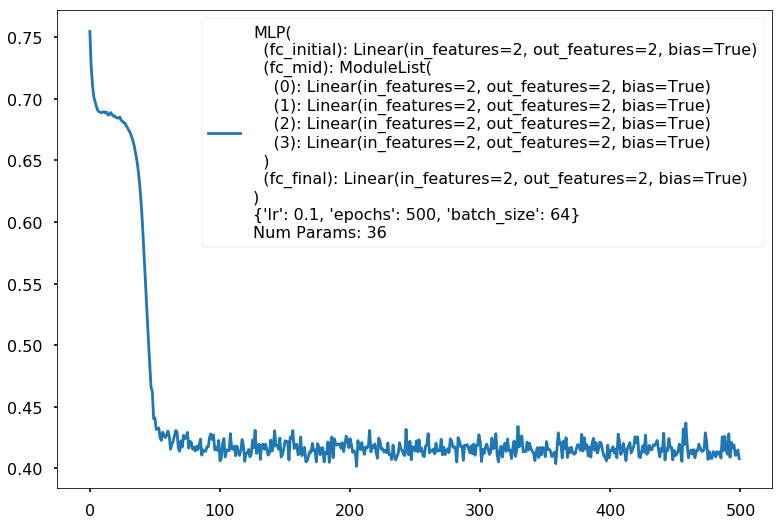

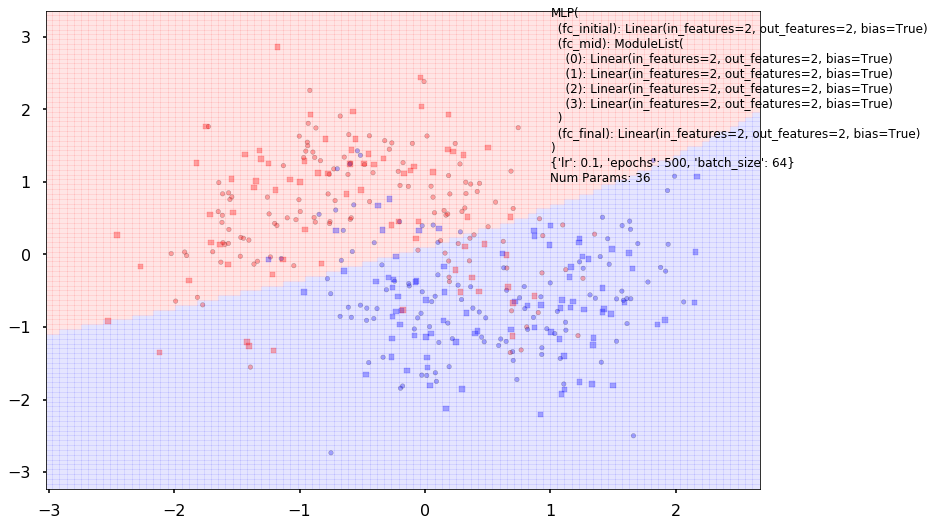

Train acc 0.8208333333333333
Test acc 0.85625
Additional 4 hidden 10
MLP(
  (fc_initial): Linear(in_features=2, out_features=10, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc_final): Linear(in_features=10, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 500, 'batch_size': 64}
Num Params: 492


Widget Javascript not detected.  It may not be installed or enabled properly.


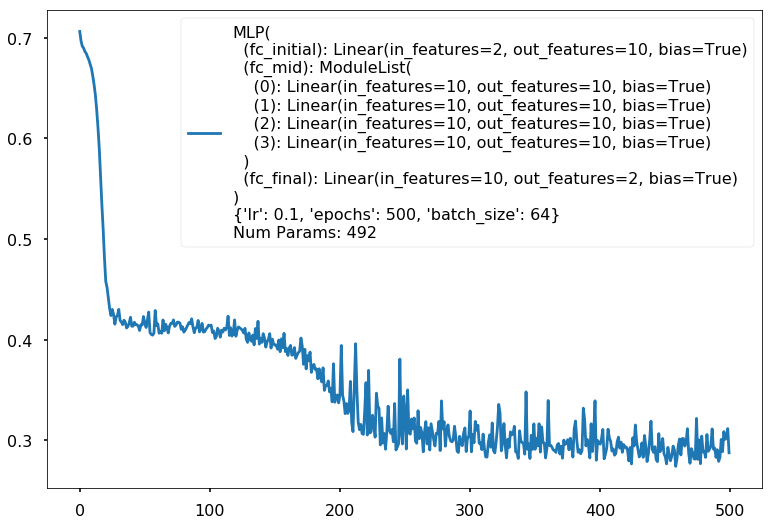

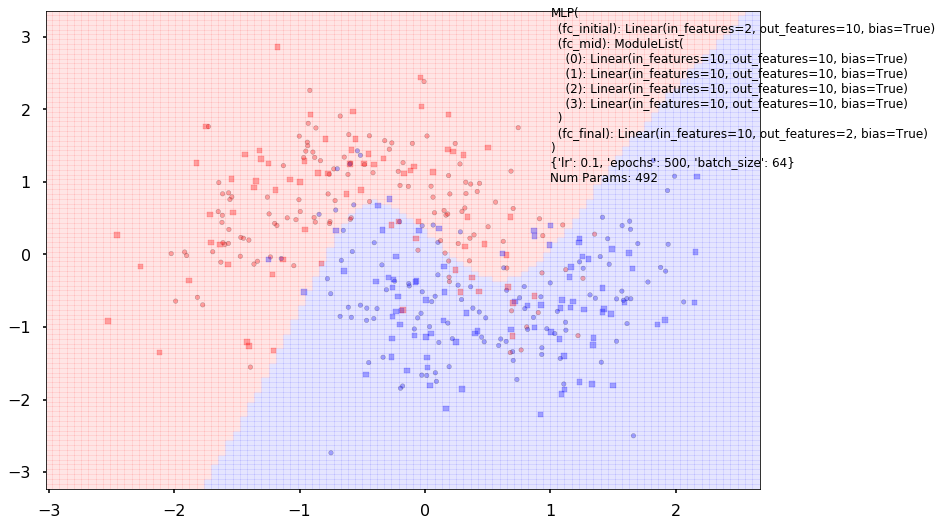

Train acc 0.8791666666666667
Test acc 0.85
Additional 4 hidden 100
MLP(
  (fc_initial): Linear(in_features=2, out_features=100, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 1000, 'batch_size': 64}
Num Params: 40902


Widget Javascript not detected.  It may not be installed or enabled properly.


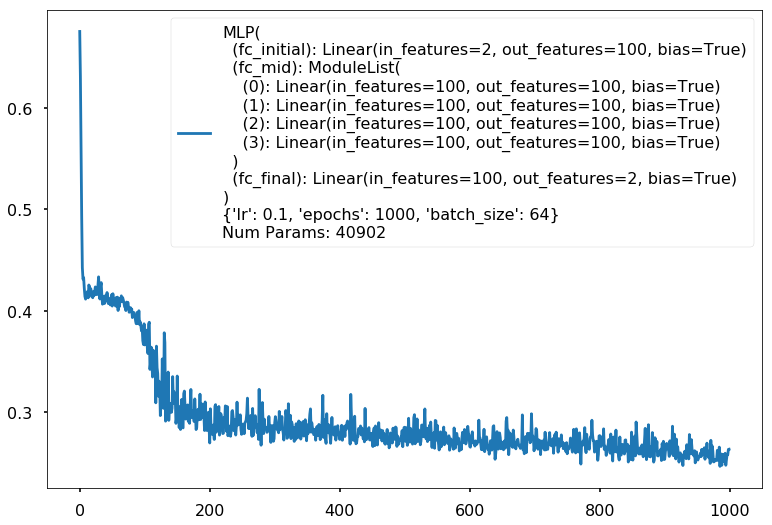

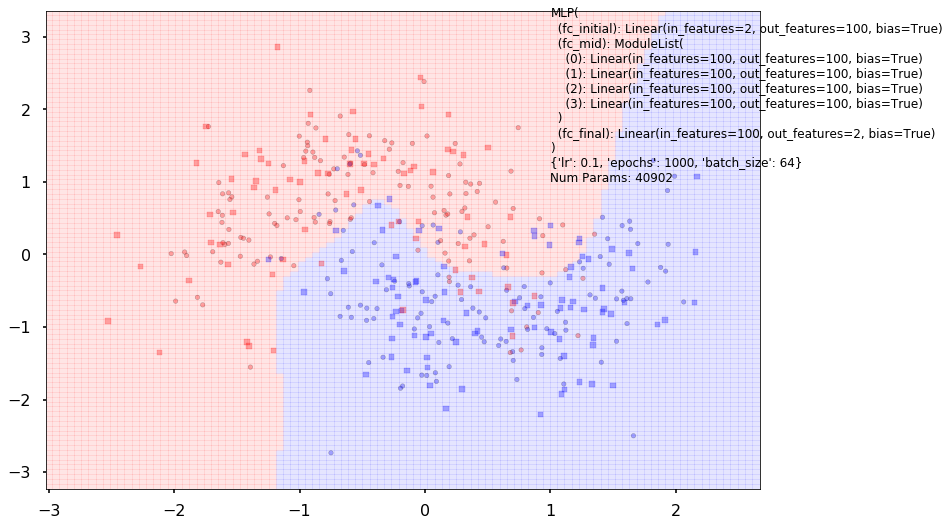

Train acc 0.8875
Test acc 0.85
Additional 4 hidden 1000
MLP(
  (fc_initial): Linear(in_features=2, out_features=1000, bias=True)
  (fc_mid): ModuleList(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
  )
  (fc_final): Linear(in_features=1000, out_features=2, bias=True)
)
{'lr': 0.1, 'epochs': 1000, 'batch_size': 64}
Num Params: 4009002


Widget Javascript not detected.  It may not be installed or enabled properly.


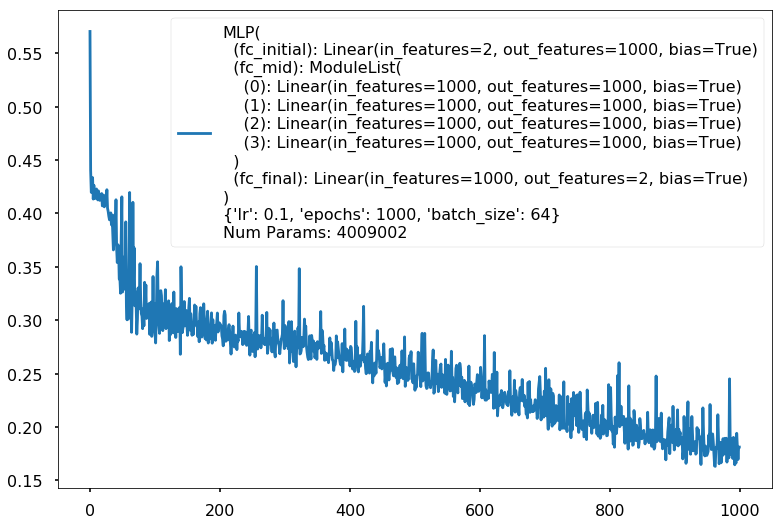

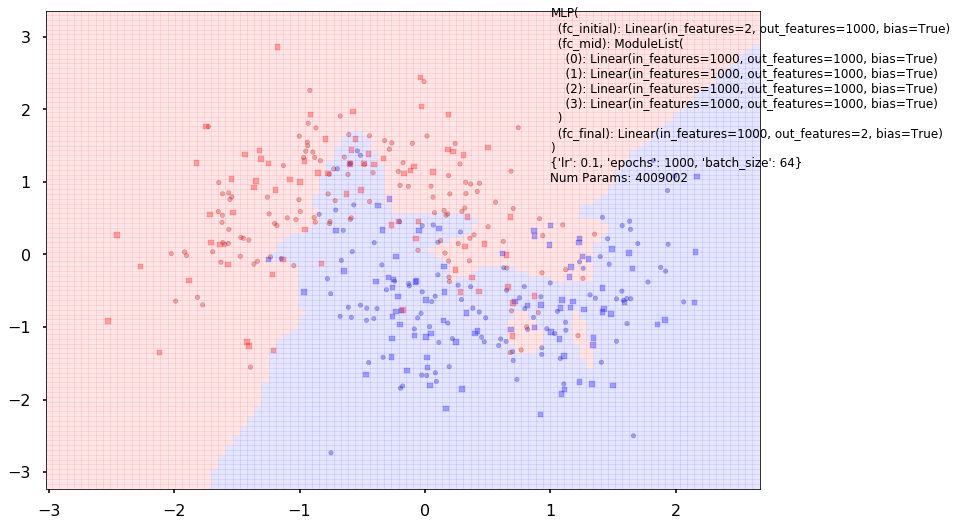

Train acc 0.8833333333333333
Test acc 0.78125


In [28]:
for additional in [0, 2, 4]:
    for hdim in [2, 10, 100, 1000]:
        print('====================')
        print('Additional', additional, "hidden", hdim)
        clf = MLPClassifier(input_dim=2, hidden_dim=hdim, output_dim=2, nonlinearity=fn.tanh, additional_hidden_wide=additional)
        if additional > 2 and hdim > 50:
            clf.set_fit_params(epochs=1000)
        else:
            clf.set_fit_params(epochs=500)
        print(clf)
        clf.fit(X_train,y_train)
        with sns.plotting_context('poster'):
            clf.plot_loss()
            clf.plot_boundary(X_train, X_test, y_train, y_test)
        print("Train acc", accuracy_score(y_train, clf.predict(X_train)))
        print("Test acc", accuracy_score(y_test, clf.predict(X_test)))


Additional 4 hidden 1000


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Widget Javascript not detected.  It may not be installed or enabled properly.


//anaconda/envs/py3l/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


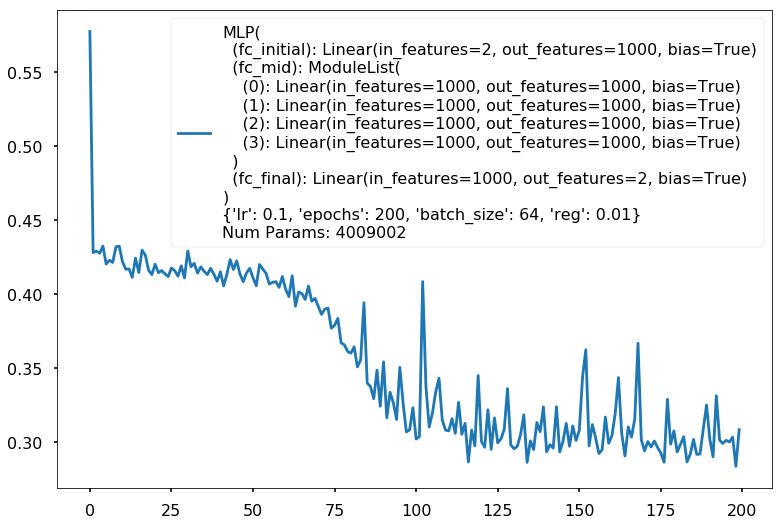

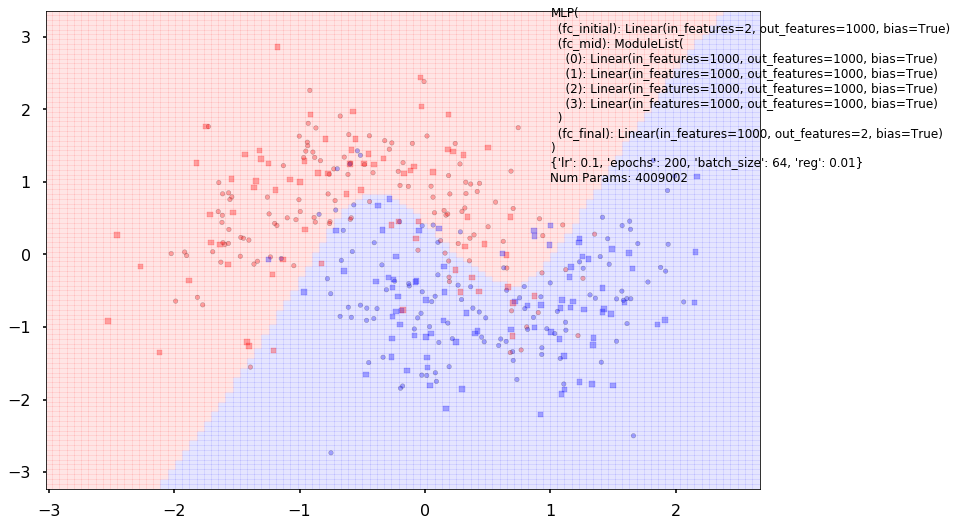

Train acc 0.875
Test acc 0.8625


In [30]:
additional=4
hidden=1000
print('====================')
print('Additional', additional, "hidden", hdim)
clf = MLPClassifier(input_dim=2, reg=0.01, hidden_dim=hdim, output_dim=2, nonlinearity=fn.tanh, additional_hidden_wide=additional)
clf.fit(X_train,y_train)
with sns.plotting_context('poster'):
    clf.plot_loss()
    clf.plot_boundary(X_train, X_test, y_train, y_test)
print("Train acc", accuracy_score(y_train, clf.predict(X_train)))
print("Test acc", accuracy_score(y_test, clf.predict(X_test)))